# Titanic

In [1]:
%%capture

from functools import partial
from pathlib import Path
from typing import Callable, Dict, List, Tuple
import os

is_titanic_dir = str(Path(os.getcwd())).rsplit("\\")[-1] == "Titanic"

if is_titanic_dir:
    os.chdir("../")

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
from xgboost import XGBClassifier

from mlutils.model.baseline import AutoMLBaseline
from mlutils.preprocess.missing import check_missingness
from mlutils.visualise.features import (
    feature_correlation_plot, 
    plot_importances, 
    plot_pct_by_group
)

In [2]:
def preprocessing_pipeline(
    df: pd.DataFrame, 
    pipeline: Dict[str, Tuple[Callable, dict]],
) -> pd.DataFrame:
    """Applies all preprocessing steps to df

    Args:
        df (pd.DataFrame): input df
        function_list (Dict[str, Tuple[Callable, dict]]): dictionary where keys are arbitrary names, and values are tuple
        of 

    Returns:
        pd.DataFrame: preproocessed df
    """
    for step, (func, kwargs) in pipeline.items():
        print(f"Running pipeline step: {step}")
        if kwargs is None:
            kwargs = {}
        df = func(df, **kwargs)
    
    return df

def extract_x_y(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """Split into X and y for modelling

    Args:
        df (pd.DataFrame): train/test set
        target_col (str): target column name

    Returns:
        Tuple[pd.DataFrame, pd.Series]: X and y
    """
    X, y = df.drop(target_col, axis=1), df[target_col]
    return X, y

### Load data

In [3]:
sns.set(rc={'figure.figsize':(10, 5)})

TARGET = "Survived"

def load_raw_data(data_set: str="train") -> pd.DataFrame:

    if data_set == "test":
        df = pd.read_csv("Titanic/Data/test.csv")
    else:
        df = pd.read_csv("Titanic/Data/train.csv")

    return df

train = load_raw_data("train")
test = load_raw_data("test")

# Initialise empty pipeline
pipeline = {}

DROP_COLS = [
    "Ticket",
    "Name"
]

def drop_cols(df: pd.DataFrame, drop_cols: List[str]) -> pd.DataFrame:
    return df.drop(drop_cols, axis=1)

train = drop_cols(train, DROP_COLS)
test = drop_cols(test, DROP_COLS)

### EDA

Basic was EDA done locally and scrapped, so won't appear here

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 0, '%')

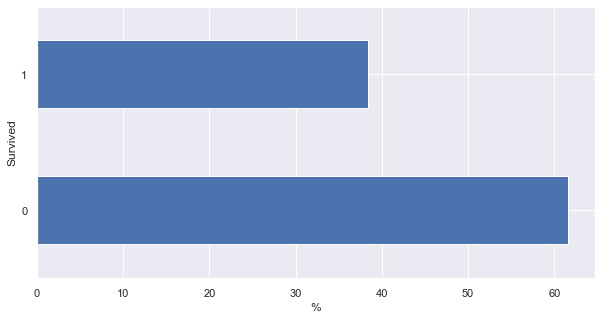

In [5]:
ax = (train["Survived"].value_counts() / len(train) * 100).plot(kind="barh")
ax.set_ylabel("Survived")
ax.set_xlabel("%")

**Cabin**

The Cabin field consists of a single letter followed by a number.

It is assumed that the first letter indicates the area of the boat the cabin was in, and the number signifies room number within that area. The area of the boat the passenger was in could be informative of probability of survival.

<AxesSubplot:xlabel='cabin_location', ylabel='Survived'>

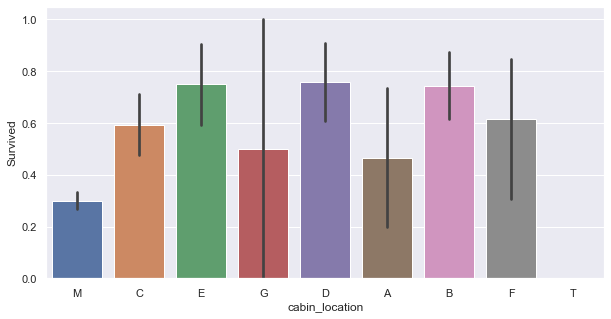

In [6]:
def extract_cabin_features(df):
    # Create cabin location and number cols
    df["cabin_location"] = df["Cabin"].str.slice(0, 1)

    # Impute
    df["cabin_location"].fillna("M", inplace=True)
    df.drop("Cabin", axis=1, inplace=True)
    
    return df

_ = train.copy()
_ = extract_cabin_features(_)
sns.barplot(data=_, x="cabin_location", y="Survived")

1    687
0    204
Name: cabin_M, dtype: int64


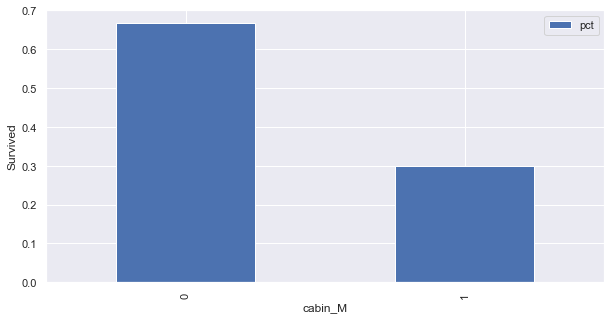

In [7]:
_["cabin_M"] = np.where(_["cabin_location"] == "M", 1, 0)
_.drop("cabin_location", axis=1, inplace=True)

print(_["cabin_M"].value_counts())
plot_pct_by_group(_, "Survived", "cabin_M", kind="bar")

**Just keep feature, cabin_M - other cabin categories are less frequent and have less impact on survival**

### Missing data

**For now impute Age and Embarked with median and mode**

In [8]:
def impute(df: pd.DataFrame) -> pd.DataFrame:
    # Age - if any remaining after this (don't have a group), impute with median
    df["Age"] = df.groupby(["Pclass", "Sex", "Parch"])["Age"].apply(lambda x: x.fillna(x.median()))
    
    # Embarked
    df["Embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["Embarked"]])

    # Impute remaining with median
    median_impute_cols = ["Fare", "Age"]
    for median_impute_col in median_impute_cols:
        df[median_impute_col] = SimpleImputer(strategy="most_frequent").fit_transform(df[[median_impute_col]])

    return df

pipeline["impute"] = (impute, None)

### Feature engineering

In [9]:
def extract_cabin_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add feature to signal missing cabin data"""

    df["cabin_location"] = df["Cabin"].str.slice(0, 1)
    df["cabin_location"].fillna("M", inplace=True)
    df["cabin_M"] = np.where(df["cabin_location"] == "M", 1, 0)
    df.drop(["Cabin", "cabin_location"], axis=1, inplace=True)
    return df

pipeline["extract cabin features"] = (extract_cabin_features, None)

### Preprocessing

In [10]:
def cols_to_char(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    for col in cols:
        df[col] = df[col].astype(str)
    return df

def ohe(df: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(df, drop_first=True)

def add_family_size(df: pd.DataFrame) -> pd.DataFrame:
    df["family_size"] = df['SibSp'] + df['Parch'] + 1
    df.drop(["SibSp", "Parch"], axis=1, inplace=True)
    return df
    
pipeline["cols_to_char"] = (cols_to_char, {"cols": ["Pclass"]})
pipeline["ohe"] = (ohe, None)
pipeline["family size"] = (add_family_size, None)

In [11]:
%%capture
train = preprocessing_pipeline(train, pipeline)
test = preprocessing_pipeline(test, pipeline)

In [12]:
X, y = extract_x_y(train, "Survived")
X.drop("PassengerId", axis=1, inplace=True)

### Baseline model

In [13]:
%%capture
baseline_performance = AutoMLBaseline(X, y, scoring="accuracy", n_cv=10).run_experiment()

In [16]:
baseline_performance

,score
XGBClassifier,0.815943
RandomForestClassifier,0.813758
LogisticRegression,0.808065
GaussianNB,0.786767
MLPClassifier,0.730749
SVC,0.685843
DummyClassifier,0.616167


### XGBoost

In [15]:
param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(3, 8),
    'learning_rate': [.2, .3, .4],
    'colsample_bytree': [.7, .8, .9, 1]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid,
    cv=10, 
    n_jobs=-1, 
)
grid_search.fit(X, y)

[17:42:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [30]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.4,
 'max_depth': 7,
 'n_estimators': 12}

In [31]:
%%capture

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, KFold

N_CV = 10
kfold = KFold(n_splits=N_CV, shuffle=True)


# xgb = XGBClassifier(**grid_search.best_params_)
xgb = XGBClassifier(**{
    'colsample_bytree': 0.7,
    'learning_rate': 0.4,
    'max_depth': 6,
    'n_estimators': 12
})
train_accuracy, test_accuracy = [], []

for train_idx, test_idx in kfold.split(X, y):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]

    xgb.fit(X_train, y_train)
    y_hat_train = xgb.predict(X_train)
    y_hat_test = xgb.predict(X_test)

    train_accuracy.append(accuracy_score(y_train, y_hat_train))
    test_accuracy.append(accuracy_score(y_test, y_hat_test))

Mean train score 0.9102136979648258
Mean test score 0.8316853932584269


<AxesSubplot:xlabel='fold', ylabel='accuracy'>

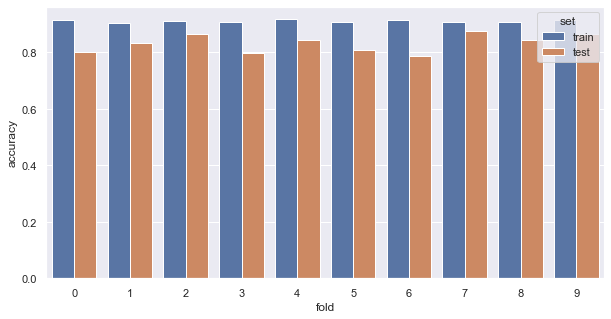

In [32]:
results_df = pd.DataFrame({
    "fold": list(range(N_CV)),
    "train": train_accuracy,
    "test": test_accuracy
})
results_df = pd.melt(results_df, id_vars="fold", var_name="set",value_name="accuracy")
print(f"Mean train score {np.mean(train_accuracy)}")
print(f"Mean test score {np.mean(test_accuracy)}")
sns.barplot(data=results_df, x="fold", y="accuracy", hue="set")

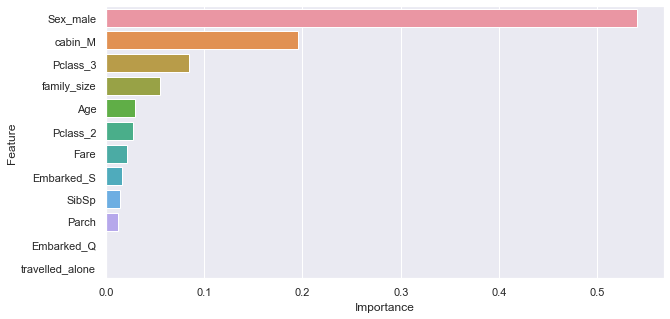

In [34]:
plot_importances(xgb, X.columns, 20)

### Score test set and submit

In [20]:
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=12, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)>

In [22]:
xgb.fit(X, y)

[17:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=12, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
missing_features = list(
    set(X) -
    set(test.drop("PassengerId", axis=1).columns)
)
print(f"Adding missing features to test set: {missing_features}")
for missing_feature in missing_features:
    test[missing_feature] = 0

Adding missing features to test set: []


In [25]:
%%capture
y_hats = test[["PassengerId"]]
y_hats["Survived"] = xgb.predict(test.drop("PassengerId", axis=1))
y_hats.to_csv("Titanic/Data/test_predictions.csv", index=False)